# [Module 5] 예측 결과 분석 하기 (Analyze a Target Forecast)

이 노트북은 얼마나 예측이 잘 되었는지를 모듈 1에서 생성한 검증셋과 비교를 하여 정확도를 계산 합니다. 또한 CNN-QR, Prophet, DeepAR+ 의 두개 정확도의 비교를 합니다.

아래와 같은 작업을 수행 합니다.

- S3의 Forecast 결과를 로컬에 다운로드
- Forecast 예측 결과 확인
- Forecast 예측 결과 포맷 변경
- Actual 값 준비
- forecast 예측 결과와 Actual 값의 조인
- 3개 알고리즘의 MAPE metric 확인
- Forecast에 단일 Query 실행 예제
- Prophet vs. DeeparP, DeepARP vs. CNN-QR, 차트 비교

---
이 노트북은 약 10분 정도 소요 됩니다. (About 10 mins may be elapsed)

In [1]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
# 다른 노트북에서 저장된 변수들을 불러옴
%store -r

In [3]:
session = boto3.Session(region_name=region)
forecast = session.client(service_name='forecast')
forecast_query = session.client(service_name='forecastquery')

## S3의 Forecast 결과를 로컬에 다운로드

아래의 작업은 S3에 저장된 예측 결과를 이 노트북 인스턴스에 다운로드 하는 과정 입니다. 로컬에 폴더를 만들고 다운로드 합니다. 

In [4]:
import os
cnnqr_result_dir = "cnnqr" + suffix
prophet_result_dir = "prophet" + suffix
deepar_result_dir = "deeparp" + suffix

os.makedirs(cnnqr_result_dir, exist_ok=True)
os.makedirs(prophet_result_dir, exist_ok=True)
os.makedirs(deepar_result_dir, exist_ok=True)

In [5]:
def download_forecast_result(result_dir, bucket_name, bucket_folder, forecast_name,target_suffix, suffix):
    s3 = boto3.resource('s3')
    poc_bucket = boto3.resource('s3').Bucket(bucket_name)
    prefix = bucket_folder + "/" +  forecast_name + "_" + target_suffix + suffix
    result_filenames = ""
    forecast_files = list(poc_bucket.objects.filter(Prefix=prefix))
    for file in forecast_files:
        # There will be a collection of CSVs if the forecast is large, modify this to go get them all
        if "csv" in file.key:
            result_filenames = file.key.split('/')[2]
            s3.Bucket(bucket_name).download_file(file.key, result_dir+"/"+result_filenames)

download_forecast_result(cnnqr_result_dir, bucket_name, bucket_folder, "cnnqr",target_suffix, suffix)            
download_forecast_result(prophet_result_dir, bucket_name, bucket_folder, "prophet",target_suffix, suffix)            
download_forecast_result(deepar_result_dir, bucket_name, bucket_folder, "deeparp",target_suffix, suffix)            


#### 다운로드 된 복수개의 파일을 1개의 데이타프레임으로 저장

In [6]:
def getTotalForecastResult(resultFolder):
    """
    Return a dataframe containing all forecast files in the folder passed
    """
    total_predicts_s3 = pd.DataFrame()
    for file in os.listdir(resultFolder):
        predicts_s3 = pd.read_csv(resultFolder + "/" + file)
        total_predicts_s3 = total_predicts_s3.append(predicts_s3)
    total_predicts_s3 = total_predicts_s3.sort_values(by=['item_id', 'date', 'store'])        
    return total_predicts_s3
    

cnnqr_predicts_s3 = getTotalForecastResult(cnnqr_result_dir)        
prophet_predicts_s3 = getTotalForecastResult(prophet_result_dir)    
deeparp_predicts_s3 = getTotalForecastResult(deepar_result_dir)    


3 개의 데이타 프레임에 저장된 컬럼 정보를 확인 합니다.

In [7]:
cnnqr_predicts_s3.info()
prophet_predicts_s3.info()
deeparp_predicts_s3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15500 entries, 155 to 712
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   item_id  15500 non-null  int64  
 1   date     15500 non-null  object 
 2   store    15500 non-null  int64  
 3   p10      15500 non-null  float64
 4   p50      15500 non-null  float64
 5   p90      15500 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 847.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15500 entries, 1333 to 1890
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   item_id  15500 non-null  int64  
 1   date     15500 non-null  object 
 2   store    15500 non-null  int64  
 3   p10      15500 non-null  float64
 4   p50      15500 non-null  float64
 5   p90      15500 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 847.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Ind

다운로드 받은 파일의 폴더를 제거 합니다.

In [8]:
# Remove the folders already used
! rm -rf {cnnqr_result_dir}
! rm -rf {prophet_result_dir}
! rm -rf {deepar_result_dir}

## Forecast 예측 결과 확인

아래는 deeparp 의 결과이고, 예로서 데이타의 해석의 방법은 첫번째 Row의 경우에 item_id 1 이 2017년 12월 1일에 Store1에서 p10 기준으로 약 14개가 팔리고, p50 기준으로 약 21가 팔리고, p90 기준으로 약 28개가 팔릴 것으로 예측을 하였습니다. 

In [9]:
deeparp_predicts = deeparp_predicts_s3.copy()
deeparp_predicts.head()


,item_id,date,store,p10,p50,p90
124,1,2017-12-01T00:00:00Z,1,14.0,21.0,28.0
434,1,2017-12-01T00:00:00Z,2,26.0,32.0,38.0
155,1,2017-12-01T00:00:00Z,3,19.0,25.0,33.0
1147,1,2017-12-01T00:00:00Z,4,19.0,26.0,31.0
248,1,2017-12-01T00:00:00Z,5,13.0,19.0,24.0


In [10]:
# CNN-QR
cnnqr_predicts = cnnqr_predicts_s3.copy()
cnnqr_predicts.head()

,item_id,date,store,p10,p50,p90
155,1,2017-12-01T00:00:00Z,1,14.049633,19.871408,26.946194
434,1,2017-12-01T00:00:00Z,2,23.974312,31.187569,40.226940
217,1,2017-12-01T00:00:00Z,3,20.529102,27.542063,36.007088
1147,1,2017-12-01T00:00:00Z,4,18.076138,24.677046,32.991684
248,1,2017-12-01T00:00:00Z,5,11.532332,17.212666,24.651848


In [11]:
# Prophet
prophet_predicts = prophet_predicts_s3.copy()
prophet_predicts.head()

,item_id,date,store,p10,p50,p90
1333,1,2017-12-01T00:00:00Z,1,15.934486,21.087253,26.007329
434,1,2017-12-01T00:00:00Z,2,25.932432,32.101936,37.992834
3751,1,2017-12-01T00:00:00Z,3,20.769555,28.035067,33.702552
1147,1,2017-12-01T00:00:00Z,4,19.232389,24.781836,31.343757
248,1,2017-12-01T00:00:00Z,5,12.623689,18.639854,23.332782


## Forecast 예측 결과 포맷 변경

아래는 실제 Actual 값 (validation_time_series.csv) 과 비교를 위해서 포맷을 바꾸는 작업을 합니다.

In [12]:
def format_forecast_result(predicts_s3):
    # Remove the timezone
    predicts = predicts_s3.copy()
    predicts['date'] = pd.to_datetime(predicts['date']) 
    predicts['date'] = predicts['date'].dt.tz_convert(None) # Convert time zone
    predicts.date = pd.to_datetime(predicts.date, format= '%Y-%m-%d') # Change a format of yyyy-mm-dd
    predicts.item_id = predicts.item_id.astype(str) # convert to string type
    predicts.store = predicts.store.astype(str) # convert to string type
    predicts = predicts[['date','item_id','store','p10', 'p50', 'p90']]
    
    return predicts

In [13]:
prophet_predicts = format_forecast_result(prophet_predicts_s3)
prophet_predicts.head(2)

,date,item_id,store,p10,p50,p90
1333,2017-12-01,1,1,15.934486,21.087253,26.007329
434,2017-12-01,1,2,25.932432,32.101936,37.992834


In [14]:
cnnqr_predicts = format_forecast_result(cnnqr_predicts_s3)
cnnqr_predicts.head(2)

,date,item_id,store,p10,p50,p90
155,2017-12-01,1,1,14.049633,19.871408,26.946194
434,2017-12-01,1,2,23.974312,31.187569,40.226940


In [15]:
deeparp_predicts = format_forecast_result(deeparp_predicts_s3)
deeparp_predicts.head(2)


,date,item_id,store,p10,p50,p90
124,2017-12-01,1,1,14.0,21.0,28.0
434,2017-12-01,1,2,26.0,32.0,38.0


## Actual 값 준비

Module 1에서 준비한 검증 데이타 셋 (2017년 12월 데이터)를 가져옵니다.

In [16]:
validation_df = validation_stores_sales.copy()
validation_df.reset_index(inplace=True) # reset index
validation_df = validation_df.rename(columns={'index':'date'}) # Change column name to date
validation_df.date = pd.to_datetime(validation_df.date, format= '%Y-%m-%d') # Change a format of yyyy-mm-dd
validation_df.head()

,date,item_id,store,sales
0,2017-12-01,1,1,19
1,2017-12-02,1,1,16
2,2017-12-03,1,1,31
3,2017-12-04,1,1,7
4,2017-12-05,1,1,20


## forecast 예측 결과와 Actual 값의 조인

실제로 예측된 결과 (Prophet) 와 검증 셋 데이타를 조인해서, 한개의 데이타 프레임으로 보이게 합니다. 여기서 실제로 얼마나 잘 예측을 했는지를 눈으로 확인할 수 있습니다.

In [17]:
# Prophet
prophet_val_df = pd.merge(prophet_predicts,validation_df, 
                          on=['date', 'item_id','store'], 
                          how='inner')
                          
prophet_val_df.set_index('date', inplace=True)
prophet_val_df.head(2)

,item_id,store,p10,p50,p90,sales
date,,,,,,
2017-12-01,1,1,15.934486,21.087253,26.007329,19
2017-12-01,1,2,25.932432,32.101936,37.992834,31


같은 작업을 DeepAR+ 에서도 합니다.

In [18]:
# deeparp
deeparp_val_df = pd.merge(deeparp_predicts,validation_df, 
                          on=['date', 'item_id','store'], 
                          how='inner')
                          
deeparp_val_df.set_index('date', inplace=True)
deeparp_val_df.head(2)

,item_id,store,p10,p50,p90,sales
date,,,,,,
2017-12-01,1,1,14.0,21.0,28.0,19
2017-12-01,1,2,26.0,32.0,38.0,31


같은 작업을 CNN-QR 에서도 합니다.

In [19]:
# cnn-qr
cnnqr_val_df = pd.merge(cnnqr_predicts,validation_df, 
                          on=['date', 'item_id','store'], 
                          how='inner')
                          
cnnqr_val_df.set_index('date', inplace=True)
cnnqr_val_df.head(2)

,item_id,store,p10,p50,p90,sales
date,,,,,,
2017-12-01,1,1,14.049633,19.871408,26.946194,19
2017-12-01,1,2,23.974312,31.187569,40.226940,31


## 3개 알고리즘의 MAPE metric 확인
- MAPE 는 에러 지표의 하나로서, 아래 mape_p50이 0.18이면 정확도는 1-0.18 = 0.82로서 약 82%의 정확도를 보임.

In [20]:
def show_MAPE_metric(algo_val_df):
    val_metric_df = algo_val_df.copy()
    n_rows = val_metric_df.shape[0]
    val_metric_df['mape_p50'] = (abs(val_metric_df.sales - val_metric_df.p50) / val_metric_df.sales ) 
    mape = val_metric_df['mape_p50'].mean()
    
    return mape, val_metric_df

In [21]:
prophet_mape, prophet_val_metric_df = show_MAPE_metric(prophet_val_df)
deeparp_mape, deeparp_val_metric_df = show_MAPE_metric(deeparp_val_df)
cnnqr_mape, cnnqr_val_metric_df = show_MAPE_metric(cnnqr_val_df)
print("Prophet MAPE: %.2f, Accuracy: %.2f" % (prophet_mape, (1-prophet_mape))  )
print("DeepARP MAPE: %.2f, Accuracy: %.2f" % (deeparp_mape, (1-deeparp_mape))  )
print("CNN-QR MAPE: %.2f, Accuracy: %.2f" % (cnnqr_mape, (1-cnnqr_mape))  )

Prophet MAPE: 0.17, Accuracy: 0.83
DeepARP MAPE: 0.17, Accuracy: 0.83
CNN-QR MAPE: 0.48, Accuracy: 0.52


In [22]:
prophet_val_metric_df.head()

,item_id,store,p10,p50,p90,sales,mape_p50
date,,,,,,,
2017-12-01,1,1,15.934486,21.087253,26.007329,19,0.109855
2017-12-01,1,2,25.932432,32.101936,37.992834,31,0.035546
2017-12-01,1,3,20.769555,28.035067,33.702552,19,0.475530
2017-12-01,1,4,19.232389,24.781836,31.343757,17,0.457755
2017-12-01,1,5,12.623689,18.639854,23.332782,9,1.071095


In [23]:
deeparp_val_metric_df.head()

,item_id,store,p10,p50,p90,sales,mape_p50
date,,,,,,,
2017-12-01,1,1,14.0,21.0,28.0,19,0.105263
2017-12-01,1,2,26.0,32.0,38.0,31,0.032258
2017-12-01,1,3,19.0,25.0,33.0,19,0.315789
2017-12-01,1,4,19.0,26.0,31.0,17,0.529412
2017-12-01,1,5,13.0,19.0,24.0,9,1.111111


In [24]:
cnnqr_val_metric_df.head()

,item_id,store,p10,p50,p90,sales,mape_p50
date,,,,,,,
2017-12-01,1,1,14.049633,19.871408,26.946194,19,0.045864
2017-12-01,1,2,23.974312,31.187569,40.226940,31,0.006051
2017-12-01,1,3,20.529102,27.542063,36.007088,19,0.449582
2017-12-01,1,4,18.076138,24.677046,32.991684,17,0.451591
2017-12-01,1,5,11.532332,17.212666,24.651848,9,0.912518


## Forecast에 단일 Query 실행 예제

**item_id , Store의 두개의 조합** 으로 12/29 - 12/31 의 예측 데이타를 볼 수 있는 예제 입니다.

In [25]:
forecast_query_response = forecast_query.query_forecast(
    ForecastArn = target_prophet_forecast_arn,
    StartDate = "2017-12-29T00:00:00",
    EndDate = "2017-12-31T00:00:00",
    Filters={"item_id": "1", "store":"1"}
)
forecast_query_response

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2017-12-29T00:00:00',
     'Value': 12.365680694580078},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 15.444621086120605},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 15.406251907348633}],
   'p50': [{'Timestamp': '2017-12-29T00:00:00', 'Value': 18.706741333007812},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 19.80170249938965},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 20.515968322753906}],
   'p90': [{'Timestamp': '2017-12-29T00:00:00', 'Value': 23.404226303100586},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 25.96634292602539},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 27.992616653442383}]}},
 'ResponseMetadata': {'RequestId': '1dd1dcb7-f695-42a3-b3c9-09598a1fdf04',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sun, 23 Aug 2020 03:41:37 GMT',
   'x-amzn-requestid': '1dd1dcb7-f695-42a3-b3c9-09598a1fdf04',
   'content-length': '619',
   'co

**item_id** 만을 가지고 예측 결과를 가져오기에 모든 Store의 전체 합산 예측값을 가져 옵니다.

In [26]:

forecast_query_response = forecast_query.query_forecast(
    ForecastArn = target_prophet_forecast_arn,
    StartDate = "2017-12-29T00:00:00",
    EndDate = "2017-12-31T00:00:00",
    Filters={"item_id":"1"}
)

forecast_query_response

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2017-12-29T00:00:00',
     'Value': 141.78428745269775},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 162.73449230194092},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 177.87921047210693}],
   'p50': [{'Timestamp': '2017-12-29T00:00:00', 'Value': 212.05366325378418},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 221.7720432281494},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 236.80402183532715}],
   'p90': [{'Timestamp': '2017-12-29T00:00:00', 'Value': 265.03885650634766},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 281.3399772644043},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 308.158203125}]}},
 'ResponseMetadata': {'RequestId': '9dfb131a-b621-41df-9dcf-9eaf00388c30',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sun, 23 Aug 2020 03:41:38 GMT',
   'x-amzn-requestid': '9dfb131a-b621-41df-9dcf-9eaf00388c30',
   'content-length': '614',
   'connect

## Prophet vs. DeeparP, DeepARP vs. CNN-QR,  차트 비교
- 아래는 Prophet, DeepAR+의 두개의 예측 결과 및 실제 값을 그래프로 그려서 시각화를 합니다.

In [27]:
from utils import show_two_chart_horizontal

In [28]:
# deeparp_val_df.item_id.unique()
# prophet_val_df.item_id.unique()
# deeparp_val_df.store.unique()

### Prophet vs. DeepARP

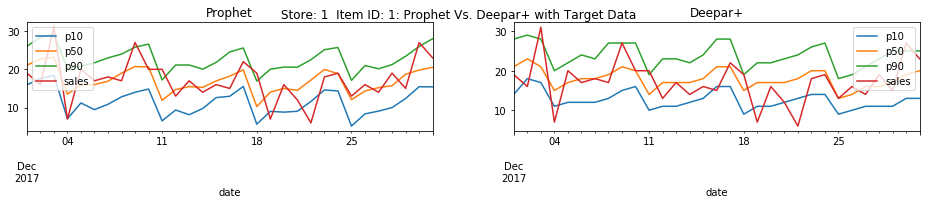

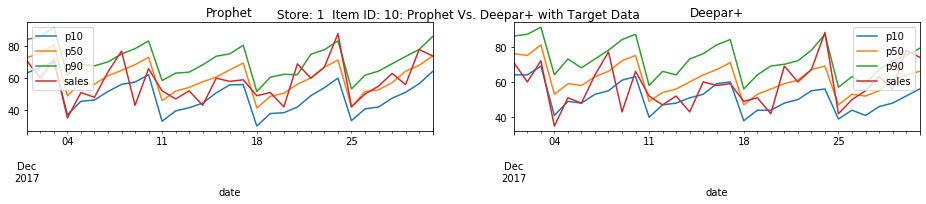

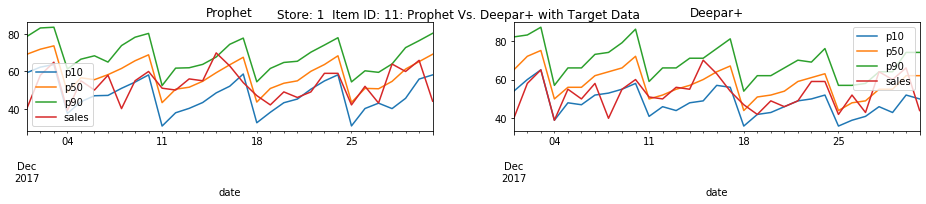

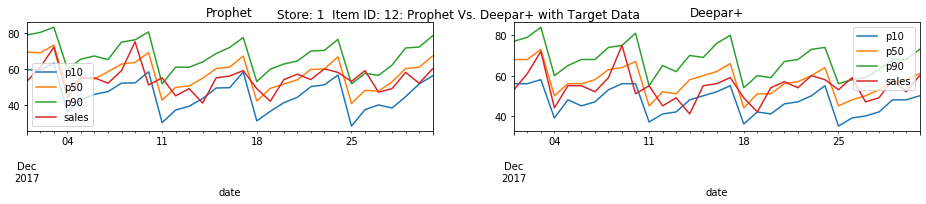

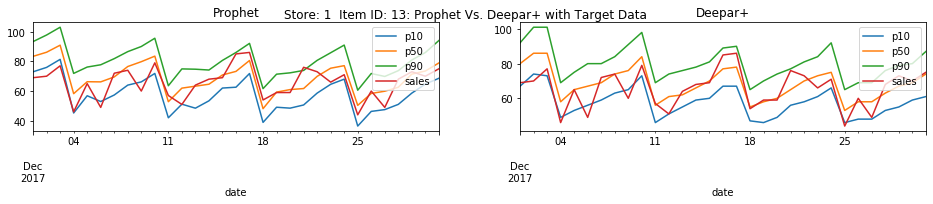

In [29]:
store_item_df = pd.DataFrame(deeparp_val_df.groupby(['store','item_id']).count())
store_item_df = store_item_df.reset_index()


display_num = 5
for i, rows in store_item_df.iterrows():
    store_id = rows['store']
    item_id = rows['item_id']    
    if display_num == i:
        break
    filter_prophet = (prophet_val_df.item_id == str(item_id)) & (prophet_val_df.store == str(store_id))
    filter_deeparp = (deeparp_val_df.item_id == str(item_id)) & (deeparp_val_df.store == str(store_id))
    
    prophet_val_single_df = prophet_val_df[filter_prophet]
    deeparp_val_single_df = deeparp_val_df[filter_deeparp]    
    plot_title = "Store: " + str(store_id) + "  Item ID: " + str(item_id) + ": Prophet Vs. Deepar+ with Target Data"
    show_two_chart_horizontal(plot_title, 
                          prophet_val_single_df, 
                          "Prophet", 
                          deeparp_val_single_df,
                          "Deepar+", 
                         )
        

### DeepARP vs. CNN-QR

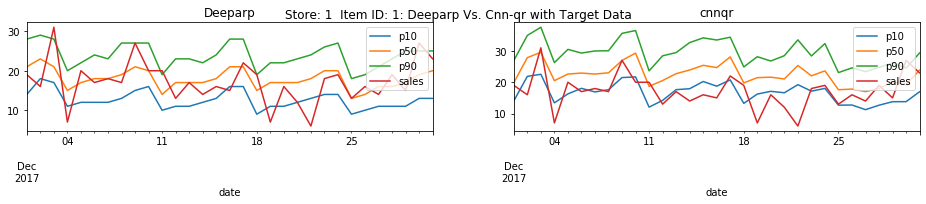

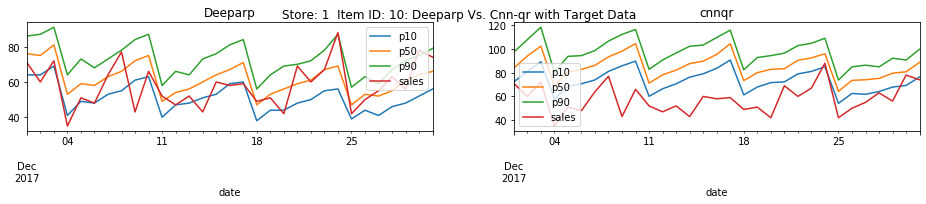

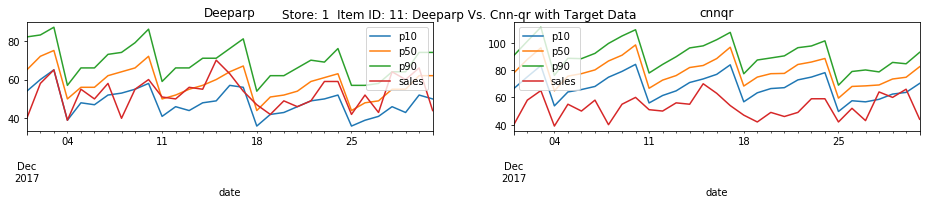

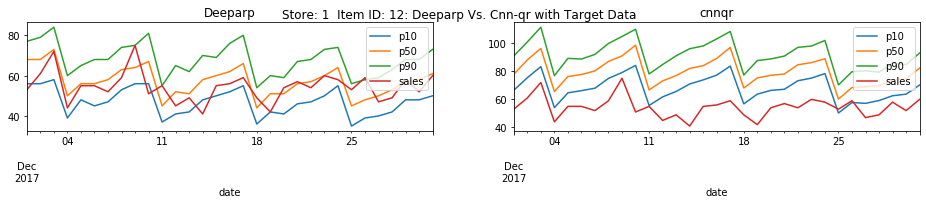

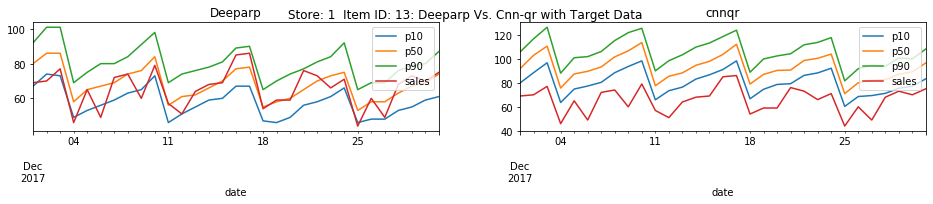

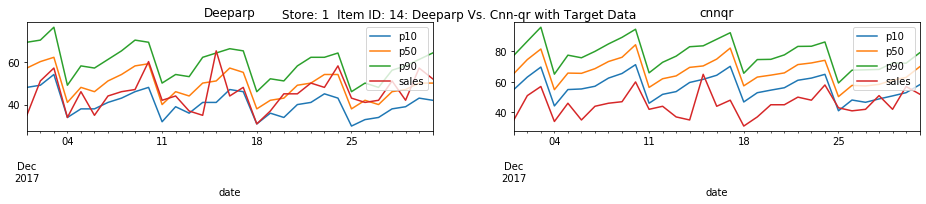

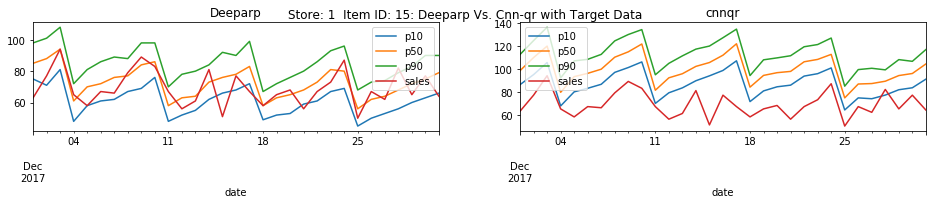

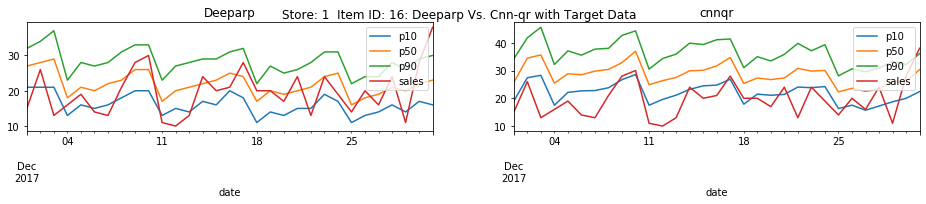

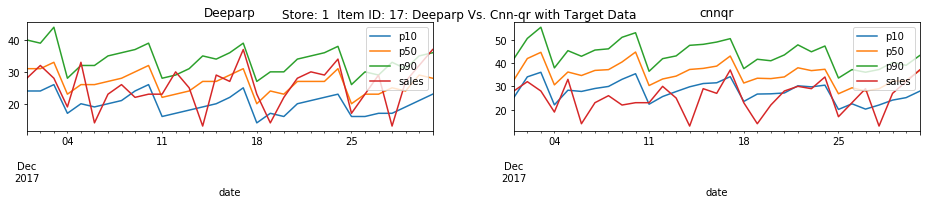

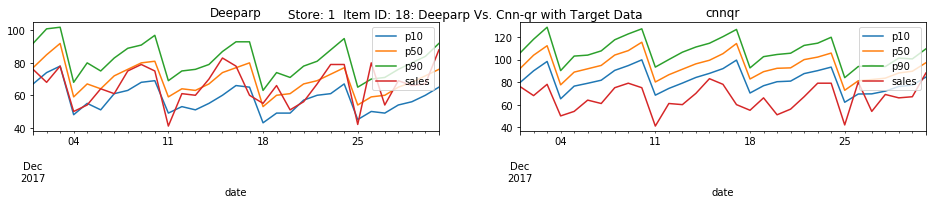

In [30]:
store_item_df = pd.DataFrame(deeparp_val_df.groupby(['store','item_id']).count())
store_item_df = store_item_df.reset_index()

display_num = 10
for i, rows in store_item_df.iterrows():
    store_id = rows['store']
    item_id = rows['item_id']    
    if display_num == i:
        break
    filter_deeparp = (deeparp_val_df.item_id == str(item_id)) & (deeparp_val_df.store == str(store_id))
    filter_cnnqr = (cnnqr_val_df.item_id == str(item_id)) & (cnnqr_val_df.store == str(store_id))    
    
    cnnqr_val_single_df = cnnqr_val_df[filter_cnnqr]
    deeparp_val_single_df = deeparp_val_df[filter_deeparp] 
    
    plot_title = "Store: " + str(store_id) + "  Item ID: " + str(item_id) + ": Deeparp Vs. Cnn-qr with Target Data"
    show_two_chart_horizontal(plot_title, 
                          deeparp_val_single_df, 
                          "Deeparp", 
                          cnnqr_val_single_df,
                          "cnnqr", 
                         )
        